<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Authors: [Vitaliy Radchenko](https://www.linkedin.com/in/vitaliyradchenk0/), and [Yury Kashnitsky](https://yorko.github.io). Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Anna Shirshova](http://linkedin.com/in/anna-shirshova-b908458b), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Topic 5. Ensembles and random forest</center>
## <center> Part 1. Bagging</center>

## Article outline

1. [Ensembles](#1.-Ensembles)
2. [Bootstrapping](#2.-Bootstrapping)
3. [Bagging](#3.-Bagging)
4. [Out-of-bag error](#4.-Out-of-bag-error)
5. [Demo assignment](#5.-Demo-assignment)
6. [Useful resources](#6.-Useful-resources)

$\DeclareMathOperator{\Var}{Var}$
$\DeclareMathOperator{\Cov}{Cov}$
$\DeclareMathOperator{\Corr}{Corr}$
$\DeclareMathOperator{\Err}{Err}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\E}{\mathbb{E}}$

In previous articles, you explored different classification algorithms as well as techniques that can be used to properly validate and evaluate the quality of your models.

Now, suppose that you have chosen the best possible model for a particular problem and are struggling to further improve its accuracy. In this case, you would need to apply some more advanced machine learning techniques that are collectively referred to as *ensembles*.

An *ensemble* is a set of elements that collectively contribute to a whole. A familiar example is a musical ensemble, which blends the sounds of several musical instruments to create harmony, or architectural ensembles, which are a set of buildings designed as a unit. In ensembles, the (whole) harmonious outcome is more important than the performance of any individual part.

## 1. Ensembles

[Condorcet's jury theorem](https://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem) (1784) is about an ensemble in some sense. It states that, if each member of the jury makes an independent judgement and the probability of the correct decision by each juror is more than 0.5, then the probability of the correct decision by the whole jury increases with the total number of jurors and tends to one. On the other hand, if the probability of being right is less than 0.5 for each juror, then the probability of the correct decision by the whole jury decreases with the number of jurors and tends to zero. 

Let's write an analytic expression for this theorem:

- $\large N$ is the total number of jurors;
- $\large m$ is a minimal number of jurors that would make a majority, that is $\large m = floor(N/2) + 1$;
- $\large {N \choose i}$ is the number of $\large i$-combinations from a set with $\large N$ elements.
- $\large p$ is the probability of the correct decision by a juror;
- $\large \mu$ is the probability of the correct decision by the whole jury.

Then:

$$ \large \mu = \sum_{i=m}^{N}{N\choose i}p^i(1-p)^{N-i} $$

It can be seen that if $\large p > 0.5$, then $\large \mu > p$. In addition, if $\large N \rightarrow \infty $, then $\large \mu \rightarrow 1$.

Let's look at another example of ensembles: an observation known as [Wisdom of the crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd). <img src="../../img/bull.png" align="right" width=15% height=15%> In 1906, [Francis Galton](https://en.wikipedia.org/wiki/Francis_Galton) visited a country fair in Plymouth where he saw a contest being held for farmers.   800 participants tried to estimate the weight of a slaughtered bull. The real weight of the bull was 1198 pounds. Although none of the farmers could guess the exact weight of the animal, the average of their predictions was 1197 pounds.


A similar idea for error reduction was adopted in the field of Machine Learning.

## 2. Bootstrapping

*Bagging* (also known as [Bootstrap aggregation](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) is one of the first and most basic ensemble techniques. It was proposed by [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) in 1994. Bagging is based on the statistical method of [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29), which makes the evaluation of many statistics of complex models feasible.

The bootstrap method goes as follows. Let there be a sample $\large X$ of size $\large N$. We can make a new sample from the original sample by drawing $\large N$ elements from the latter randomly and uniformly, with replacement. In other words, we select a random element from the original sample of size $\large N$ and do this $\large N$ times. All elements are equally likely to be selected, thus each element is drawn with the equal probability $\large \frac{1}{N}$.

Let's say we are drawing balls from a bag one at a time. At each step, the selected ball is put back into the bag so that the next selection is made equiprobably i.e. from the same number of balls $\large N$. Note that, because we put the balls back, there may be duplicates in the new sample. Let's call this new sample $\large X_1$.

By repeating this procedure $\large M$ times, we create $\large M$ *bootstrap samples* $\large X_1, \dots, X_M$. In the end, we have a sufficient number of samples and can compute various statistics of the original distribution.

![image](../../img/bootstrap_eng.png)

For our example, we'll use the familiar `telecom_churn` dataset. Previously, when we discussed feature importance, we saw that one of the most important features in this dataset is the number of calls to customer service. Let's visualize the data and look at the distribution of this feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACB40416D8>,
      dtype=object)

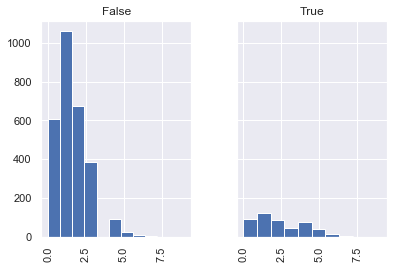

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline
from matplotlib import pyplot as plt

telecom_data = pd.read_csv('../../data/telecom_churn.csv')

# telecom_data.loc[telecom_data['Churn'] == False,
#                  'Customer service calls'].hist(label='Loyal')
# telecom_data.loc[telecom_data['Churn'] == True,
#                  'Customer service calls'].hist(label='Churn')
# plt.xlabel('Number of calls')
# plt.ylabel('Density')
# plt.legend();

telecom_data.hist(column="Customer service calls", by="Churn", sharex=True, sharey=True)



In [25]:
(telecom_data.loc[telecom_data['Churn'] == False, 'Customer service calls']).mean()

1.4498245614035088

Looks like loyal customers make fewer calls to customer service than those who eventually leave. Now, it might be a good idea to estimate the average number of customer service calls in each group. Since our dataset is small, we would not get a good estimate by simply calculating the mean of the original sample. We will be better off applying the bootstrap method. Let's generate 1000 new bootstrap samples from our original population and produce an interval estimate of the mean.

In [54]:
# def get_bootstrap_samples(data, n_samples):
#     """Generate bootstrap samples using the bootstrap method."""
#     indices = np.random.randint(0, len(data), (n_samples, len(data)))
#     samples = data[indices]
#     return samples


def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    samples = data.sample(n=n_samples*len(data), replace=True)
    return samples.values.reshape(n_samples, len(data))

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the loyal and former customers to split the dataset
loyal_calls = telecom_data.loc[telecom_data['Churn'] == False,
                               'Customer service calls'] #.values
churn_calls = telecom_data.loc[telecom_data['Churn'] == True,
                          'Customer service calls'] #.values

# Set the seed for reproducibility of the results
np.random.seed(0)

## Generate the samples using bootstrapping and calculate the mean for each of them
# loyal_mean_scores = [np.mean(sample) 
#                        for sample in get_bootstrap_samples(loyal_calls, 1000)]
# churn_mean_scores = [np.mean(sample) 
#                        for sample in get_bootstrap_samples(churn_calls, 1000)]

loyal_mean_scores = pd.DataFrame(get_bootstrap_samples(loyal_calls, 1000).T).apply(np.mean)
churn_mean_scores = pd.DataFrame(get_bootstrap_samples(churn_calls, 1000).T).apply(np.mean)

# Print the resulting interval estimates
print("Service calls from loyal: mean interval", stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn: mean interval", stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


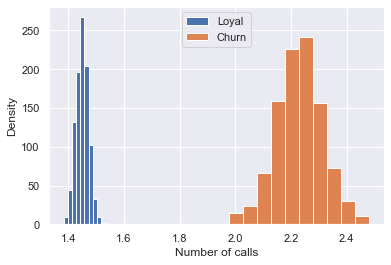

In [58]:
loyal_mean_scores.hist(label='Loyal')
churn_mean_scores.hist(label='Churn')
plt.xlabel('Number of calls')
plt.ylabel('Density')
plt.legend();

For the interpretation of confidence intervals, you can address [this](https://www.graphpad.com/guides/prism/7/statistics/stat_more_about_confidence_interval.htm?toc=0&printWindow) concise note or any course on statistics. It's not correct to say that a confidence interval contains 95% of values. Note that the interval for the loyal customers is narrower, which is reasonable since they make fewer calls (0, 1 or 2) in comparison with the churned clients who call until they are fed up and decide to switch providers. 

## 3. Bagging

Now that you've grasped the idea of bootstrapping, we can move on to *bagging*. 

Suppose that we have a training set $\large X$. Using bootstrapping, we generate samples $\large X_1, \dots, X_M$. Now, for each bootstrap sample, we train its own classifier $\large a_i(x)$. The final classifier will average the outputs from all these individual classifiers. In the case of classification, this technique corresponds to voting:
$$\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x).$$

The picture below illustrates this algorithm:
<img src="../../img/bagging.png" alt="image"/>

Let's consider a regression problem with base algorithms $\large b_1(x), \dots , b_n(x)$. Assume that there exists an ideal target function of true answers $\large y(x)$ defined for all inputs and that the distribution $\large p(x)$ is defined. We can then express the error for each regression function as follows:  

$$\large \varepsilon_i(x) = b_i(x) - y(x), \quad i = 1, \dots, n$$

And the expected value of the mean squared error:  

$$\large \E_x\left[\left(b_i(x) - y(x)\right)^{2}\right] = \E_x\left[\varepsilon_i^{2}(x)\right].$$

Then, the mean error over all regression functions will look as follows:  
$$ \large \E_1 = \frac{1}{n} \E_x\left[ \sum_i^n \varepsilon_i^{2}(x)\right]$$

We'll assume that the errors are unbiased and uncorrelated, that is: 

$$\large \begin{array}{rcl} \E_x\left[\varepsilon_i(x)\right] &=& 0, \\
\E_x\left[\varepsilon_i(x)\varepsilon_j(x)\right] &=& 0, \quad i \neq j. \end{array}$$

Now, let's construct a new regression function that will average the values from the individual functions: 

$$\large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x)$$

Let's find its mean squared error:

$$\large \begin{array}{rcl}\E_n &=& \E_x\left[\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\right]^2 \\
&=& \E_x\left[\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\right]^2 \\
&=& \frac{1}{n^2}\E_x\left[\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\right] \\
&=& \frac{1}{n}\E_1\end{array}$$

Thus, by averaging the individual answers, we reduced the mean squared error by a factor of $\large n$.

From our previous lesson, let's recall the components that make up the total out-of-sample error:

$$\large \begin{array}{rcl} 
\Err\left(\vec{x}\right) &=& \E\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \Var\left(\hat{f}\right) + \E\left[\hat{f}\right]^2 - 2f\E\left[\hat{f}\right] \\
&=& \left(f - \E\left[\hat{f}\right]\right)^2 + \Var\left(\hat{f}\right) + \sigma^2 \\
&=& \Bias\left(\hat{f}\right)^2 + \Var\left(\hat{f}\right) + \sigma^2
\end{array}$$

Bagging reduces the variance of a classifier by decreasing the difference in error when we train the model on different datasets. In other words, bagging prevents overfitting. The efficiency of bagging comes from the fact that the individual models are quite different due to the different training data and their errors cancel each other out during voting. Additionally, outliers are likely omitted in some of the training bootstrap samples.

The `scikit-learn` library supports bagging with meta-estimators `BaggingRegressor` and `BaggingClassifier`. You can use most of the algorithms as a base.

Let's examine how bagging works in practice and compare it with a decision tree. For this, we will use an example from [sklearn's documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).

![image](../../img/tree_vs_bagging_eng.png)

The error for the decision tree:
$$ \large 0.0255 \, (\Err) = 0.0003 \, (\Bias^2)  + 0.0152 \, (\Var) + 0.0098 \, (\sigma^2) $$

The error when using bagging:
$$ \large 0.0196 \, (\Err) = 0.0004 \, (\Bias^2)  + 0.0092 \, (\Var) + 0.0098 \, (\sigma^2) $$  

As you can see from the graph above, the variance in the error is much lower for bagging. Remember that we have already proved this theoretically.

Bagging is effective on small datasets. Dropping even a small part of training data leads to constructing substantially different base classifiers. If you have a large dataset, you would generate bootstrap samples of a much smaller size.

The example above is unlikely to be applicable to any real work. This is because we made a strong assumption that our individual errors are uncorrelated. More often than not, this is way too optimistic for real-world applications. When this assumption is false, the reduction in error will not be as significant. In the following lectures, we will discuss some more sophisticated ensemble methods, which enable more accurate predictions in real-world problems.

## 4. Out-of-bag error

Looking ahead, in case of Random Forest, there is no need to use cross-validation or hold-out samples in order to get an unbiased error estimation. Why? Because, in ensemble techniques, the error estimation takes place internally.
 
Random trees are constructed using different bootstrap samples of the original dataset. Approximately 37% of inputs are left out of a particular bootstrap sample and are not used in the construction of the $\large k$-th tree.

This is easy to prove. Suppose there are $\large \ell$ examples in our dataset. At each step, each data point has equal probability of ending up in a bootstrap sample with replacement, probability $\large\frac{1}{\ell}.$ The probability that there is no such bootstrap sample that contains a particular dataset element (i.e. it has been omitted $\large \ell$ times) equals $\large (1 - \frac{1}{\ell})^\ell$. When $\large \ell \rightarrow +\infty$, it becomes equal to the [Second Remarkable Limit](https://en.wikipedia.org/wiki/List_of_limits) $\large \frac{1}{e}$. Then, the probability of selecting a specific example is $\large \approx  1 - \frac{1}{e} \approx 63\%$.

Let's visualize how Out-of-Bag Error (or OOBE) estimation works:

![image](../../img/oob.png)

The top part of the figure above represents our original dataset. We split it into the training (left) and test (right) sets. In the left image, we draw a grid that perfectly divides our dataset according to classes. Now, we use the same grid to estimate the share of the correct answers on our test set. We can see that our classifier gave incorrect answers in those 4 cases that have not been used during training (on the left). Hence, the accuracy of our classifier is $\large \frac{11}{15}*100\% = 73.33\%$.

To sum up, each base algorithm is trained on $\large \approx 63\%$ of the original examples. It can be validated on the remaining $\large \approx 37\%$. The Out-of-Bag estimate is nothing more than the mean estimate of the base algorithms on those $\large \approx 37\%$ of inputs that were left out of training. 

## 5. Demo assignment
You can practice with [this assignment](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring) where you'll work with logistic regression and Random Forest in a credit scoring task. The assignment is just for you to practice, and goes with a [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol).

## 6. Useful resources
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- mlcourse.ai [lecture](https://www.youtube.com/watch?v=neXJL-AqI_c) on Random Forest
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) based on this notebook
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/324402/) on Habrahabr with ~ the same material. And a [lecture](https://youtu.be/G0DmuuFeC30) on YouTube
- Chapter 15 of the book “[Elements of Statistical Learning](https://statweb.stanford.edu/~tibs/ElemStatLearn/)” by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie.
- More about practical applications of random forests and other algorithms can be found in the [official documentation](http://scikit-learn.org/stable/modules/ensemble.html) of `scikit-learn`.
- For a more in-depth discussion of variance and decorrelation of random forests, see the [original paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf).